In [2]:
import numpy as np


def compute_velo2image_plane_matrix(velo2cam, cam2cam, cam):
    """
    This function computes the matrix needed to project the 3D velodyne points onto the 2D image plane
    :param [Dictionary] velo2cam: From calib_velo_to_cam.txt file, contains values needed for extrinsics matrix (rotation, translation)
    :param [Dictionary] cam2cam: From calib_velo_to_cam.txt file, contains values needed for intrinsics matrix (optical center, scaling)
    :param [int] cam: Camera # that matrix is being computed for (0, 1, 2, or 3)
    :return: numpy.array of shape [3,4] that converts 3D velo pts to 2D image plane velo matrix is multiplied by it 
    """
    #based on code from monodepth2 repo
    
    velo2cam = np.hstack((velo2cam['R'].reshape(3, 3), velo2cam['T'].reshape(3,1)))#Adds T vals in 4th column
    velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))
    
    R_cam2rect = np.eye(4)
    R_cam2rect[:3, :3] = cam2cam['R_rect_0'+str(cam)].reshape(3,3)#Fills top left 3x3 with R vals
    P_rect = cam2cam['P_rect_0' +str(cam)].reshape(3,4)
    
    velo2image_plane = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)
    
    return velo2image_plane

In [104]:
import numpy as np
from collections import Counter


def generate_velo_pts_im(velo, velo2image_plane):
    """
    This function removes the velo pts that are not in the image plane, rounds x/y pixel vals for velo pts, and projects the velo pts onto the image plane
    :param [numpy.array] velo: [N,4], matrix of velo pts, each column is format [X, Y, Z, Reflectance]
    :param [numpy.array] velo2image_plane: [3,4], converts 3D velo pts to 2D image plane velo matrix is multiplied by it 
    :return: numpy.array of shape [N,3], contains velo pts on image plane, each row is format [X, Y, depth]
    """
    #based on code from monodepth2 repo
    
    #remove pts behind camera
    velo = velo[velo[:,0] >=0, :]
    
    #project points to image plane
    velo_pts_im = np.dot(velo2image_plane, velo.T).T
    velo_pts_im[:, :2] = velo_pts_im[:, :2] / velo_pts_im[:, 2][..., np.newaxis]
    
   
    # get image shape
    im_shape = cam2cam["S_rect_02"][::-1].astype(np.int32)
    
    # check if in image FOV
    velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:, 0] < im_shape[1]) & (velo_pts_im[:, 1] < im_shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]
    

    return velo_pts_im

In [141]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import colorsys

def render_lidar_on_image(image, velo_pts_im):
    """
    This function plots lidar points on the image with colors corresponding to their depth(higher hsv hue val = further away) 
    :param [numpy.array] velo_pts_im: [N,3], contains velo pts on image plane, each row is format [X, Y, depth]
    :param [numpy.array] image: [H, W], contains image data
    :return: no return val, shows image w/ lidar overlay
    """
    #normalize depth vals
    depth = velo_pts_im[:, 2].reshape(-1,1)
    max = depth.max()
    min = depth.min()
    depth_norm = (depth - min)/(max-min)
    #add normalized depth vals as 4th column
    velo_pts_im = np.hstack((velo_pts_im, depth_norm))
   
    #show grayscale image
    plt.figure(figsize=(20, 20))
    ax = plt.gca()
    plt.imshow(image, cmap='Greys_r')
    
    #plot lidar points
    for row in velo_pts_im:
        norm_depth_val = row[3]
        col = colorsys.hsv_to_rgb(norm_depth_val * (240/360), 1.0, 1.0)
        circ = patches.Circle((int(row[0]),int(row[1])),2)
        circ.set_fc(col) 
        ax.add_patch(circ)
    
    plt.show()
        
        

In [142]:
def read_calib_file(path):    #taken from monodepth2 repo, for testing
    """Read KITTI calibration file
    (from https://github.com/hunse/kitti)
    """
    float_chars = set("0123456789.e+- ")
    data = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            value = value.strip()
            data[key] = value
            if float_chars.issuperset(value):
                # try to cast to float array
                try:
                    data[key] = np.array(list(map(float, value.split(' '))))
                except ValueError:
                    # casting error: data[key] already eq. value, so pass
                    pass

    return data


# Testing

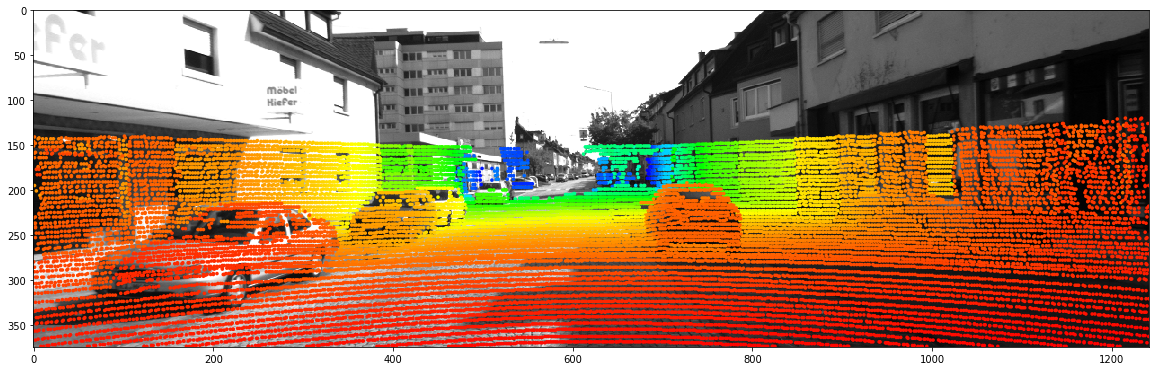

In [143]:
import matplotlib.image as mpimg
import kitti_utils

#load cam_to_cam calib file
cam2cam = read_calib_file('data/kitti_example/2011_09_26/calib_cam_to_cam.txt') 
#load velo_to_cam file
velo2cam = read_calib_file('data/kitti_example/2011_09_26/calib_velo_to_cam.txt')
#load velodyne points
velo = kitti_utils.load_velodyne_points('data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/velodyne_points/data/0000000010.bin')
#load image file
image = mpimg.imread('data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/image_00/data/0000000010.png')
velo2image_plane = compute_velo2image_plane_matrix(velo2cam, cam2cam, 0)
velo_pts_im = generate_velo_pts_im(velo, velo2image_plane)

render_lidar_on_image(image, velo_pts_im)